# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(1, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

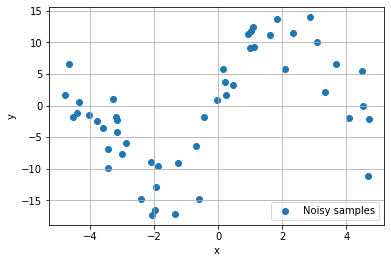

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

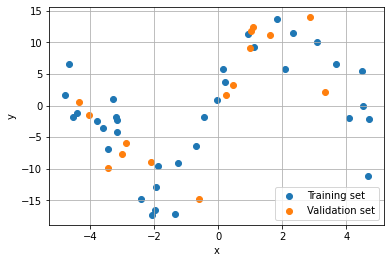

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

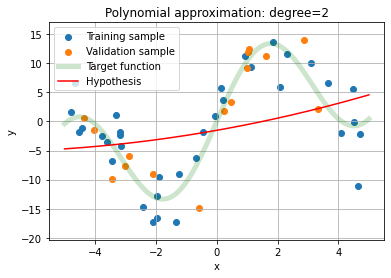

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

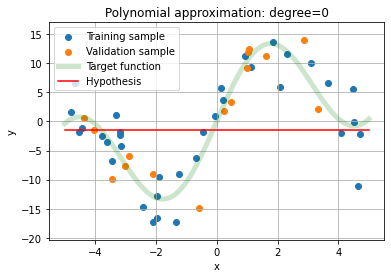

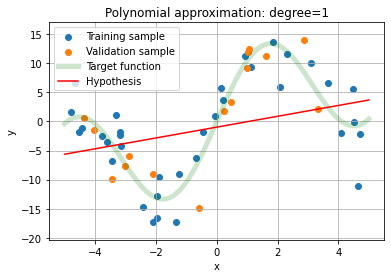

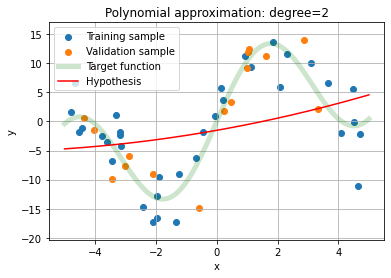

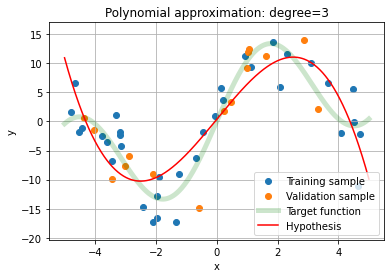

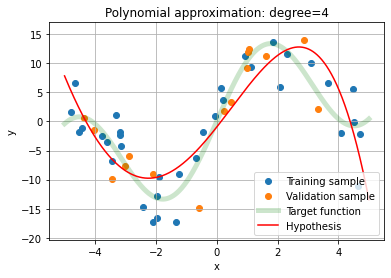

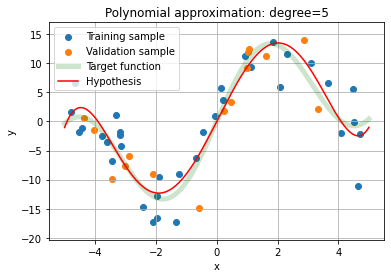

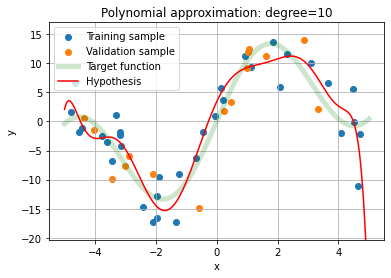

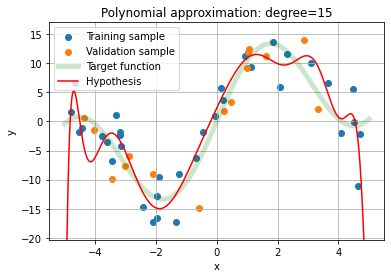

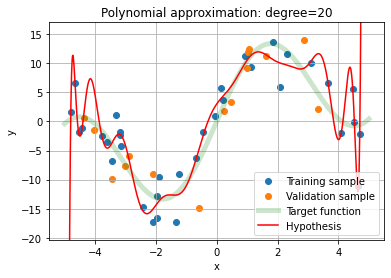

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

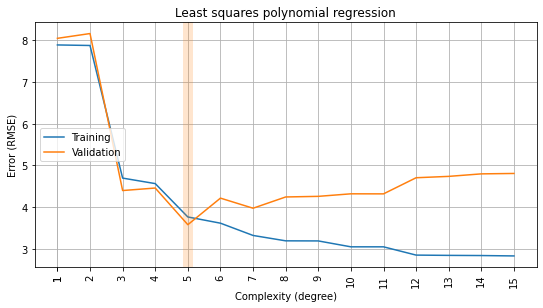

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

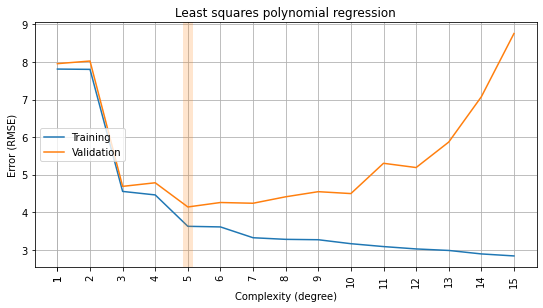

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

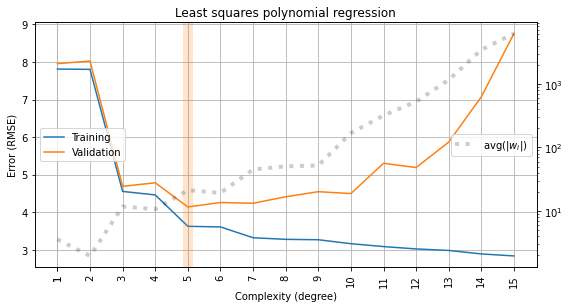

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

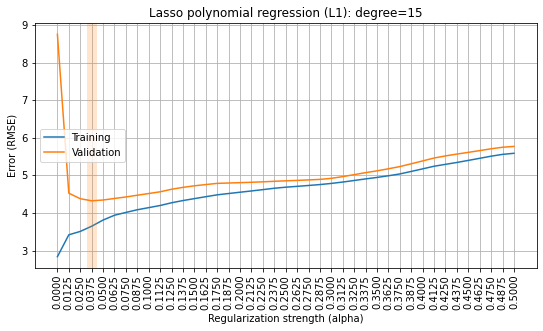

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

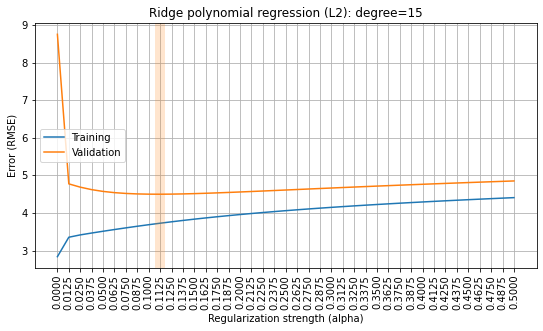

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
#y_diabetes = pd.DataFrame(data['target'], columns=['target'])
#X_diabetes = data[data['feature_names']]
y_diabetes = data['target']
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [21]:
X = X_diabetes
y = y_diabetes 
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


Изменим функцию, уберем  PolynomialFeatures, и создам функцию для добавления в датасет полимиальных признаков некоторых столбцов 

In [22]:
def make_model(alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=5000000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=5000000) 
    
    
    return Pipeline([
        
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])



In [23]:
def poly_x(X, degree, num):
    X_poly = pd.DataFrame(PolynomialFeatures(degree, include_bias=(degree == 0)).fit_transform(X.iloc[:, num:]))
                
    X = X.iloc[:, :num].join(X_poly, how='left', lsuffix='_poly', rsuffix='_poly')
    return X

In [24]:
#X = poly_x(X, 15, 7)
#X.head()


Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [25]:
#X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, random_state=SEED, test_size=0.2)
#X_train.head()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parall

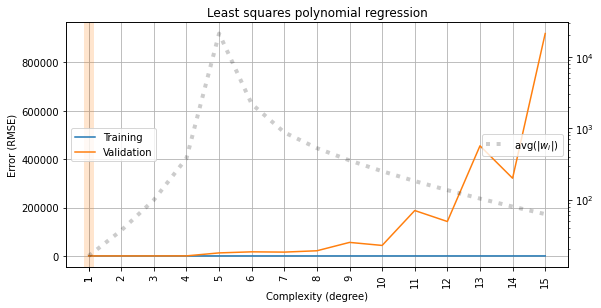

In [26]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    X = poly_x(X, degree, 5)
    X.columns = [str(i) for i in X.columns]
    results = cross_validate(make_model(),
                             X, y, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=-1,
                             verbose=10
                            )
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

    X = X_diabetes
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

На графике можно наблюдать, увеличение RMSE после добавления полимиальных признаков  (degree = 4), что свидетельствует о переобучении


### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [27]:
X = X_diabetes
X = poly_x(X, 15, 6)
X.columns = [str(i) for i in X.columns]
X.head()

,age,sex,bmi,bp,s1,s2,0,1,2,3,...,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,...,1.483295e-26,-1.314740e-26,1.165340e-26,-1.032916e-26,9.155406e-27,-8.115031e-27,7.192878e-27,-6.375515e-27,5.651032e-27,-5.008877e-27
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,...,-1.995208e-17,-2.692330e-17,-3.633026e-17,-4.902400e-17,-6.615290e-17,-8.926663e-17,-1.204562e-16,-1.625435e-16,-2.193359e-16,-2.959715e-16
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,...,3.938158e-33,-3.565850e-32,3.228740e-31,-2.923500e-30,2.647116e-29,-2.396862e-28,2.170266e-27,-1.965092e-26,1.779315e-25,-1.611102e-24
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,...,1.074103e-27,-4.431363e-28,1.828221e-28,-7.542580e-29,3.111797e-29,-1.283815e-29,5.296560e-30,-2.185170e-30,9.015224e-31,-3.719357e-31
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,...,-3.613306e-22,-5.267901e-22,-7.680162e-22,-1.119704e-21,-1.632436e-21,-2.379956e-21,-3.469778e-21,-5.058648e-21,-7.375090e-21,-1.075227e-20


В связи с очень долгим ожиданием обучения на кросс-валидации, приянято решение использовать одинарное разбиение

#### L1

1.0910336720310007e-09 117066.8156718996
[CV] START .....................................................................
[CV] END .............., score=(train=-41.561, test=-173.508) total time=   0.0s
[CV] START .....................................................................
[CV] END ............., score=(train=-0.000, test=-44534.464) total time=   0.1s
[CV] START .....................................................................
[CV] END ..............., score=(train=-52.090, test=-57.037) total time=   0.0s
[CV] START .....................................................................
[CV] END ............., score=(train=-0.000, test=-27686.246) total time=   0.0s
[CV] START .....................................................................
[CV] END ............., score=(train=-0.000, test=-96617.046) total time=   0.1s
[CV] START .....................................................................
[CV] END ............., score=(train=-22.085, test=-4613.575) total 

48.69803485854221 71.53806542139296
48.930904499794224 67.89529315987839
49.10573192555917 66.6759764494541
49.2587151758465 64.41001264501851
49.37092750222104 62.54878196721256
49.472549460649645 60.55156003150842
49.55936766743078 59.64470830394903
49.6522494945283 58.85965386127687
49.73894722216762 58.25202985582803
49.819181779536116 57.75956200255148
49.901248104858446 57.28558477644636
49.9787475712804 56.87241014743666
50.05281230805613 56.63848789769675
50.1289554093844 56.27540766214725
50.19365608455245 56.02384141632948
50.26160926852057 55.83931660214691
50.326862741384254 55.722898130949964
50.39008002375336 55.603363303873756
50.454960373744996 55.5018105447303
50.52410522822087 55.414228997639036
50.59435008824521 55.31890314587481
50.66152865240855 55.263390343049025
50.72935131095848 55.21811781180433
50.80336127945542 55.15845497909362
50.85402525024104 55.097321024491585
50.903080644307444 55.061049007002346
50.948033969625556 55.02284590572441
50.991454954607654 5

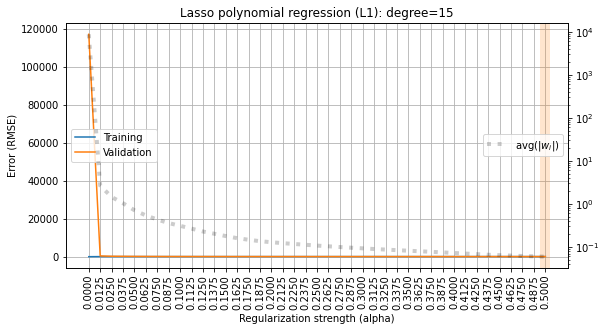

In [28]:

rmse_train, rmse_valid, avg_coef_l1= [], [] , []

for alpha in ALPHAS: 

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
    model = make_model(penalty='L1', alpha=alpha)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_score = rmse(y_train, train_pred)
    test_pred = model.predict(X_test)
    test_score = rmse(y_test, test_pred)
    rmse_train.append(train_score)
    rmse_valid.append(test_score)
    avg_coef_l1.append(       
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            
        ]))
    print(train_score, test_score)
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15');

#### L2

1.0910336720310007e-09 117066.8156718996
37.29684501100077 300.4120075151455
38.571562181793055 226.06216439388257
39.30777630820655 203.5498346141234
39.82461831607059 191.26433852230141
40.221025301027545 182.4801309722423
40.54162280144204 175.42309539784426
40.81041387574234 169.4386143303546
41.04174227206825 164.21680346564128
41.24481724072517 159.58165967498084
41.42587350142549 155.41962418973392
41.58931007375831 151.65079408852472
41.73833620207566 148.21554565695985
41.87535898655848 145.06754379733863
42.00222678426208 142.16972104386392
42.12038786415219 139.49177965778767
42.23099713278062 137.00854235528294
42.334989894821355 134.69880982351853
42.43313404387848 132.54453876010126
42.52606776372741 130.53023242042693
42.61432726849589 128.64247762841214
42.69836755302786 126.86958598320003
42.77857814744276 125.20131118267082
42.855295241442306 123.62862317563393
42.928811130693205 122.14352554547287
42.99938166051389 120.73890630116348
43.06723215286529 119.40841484135

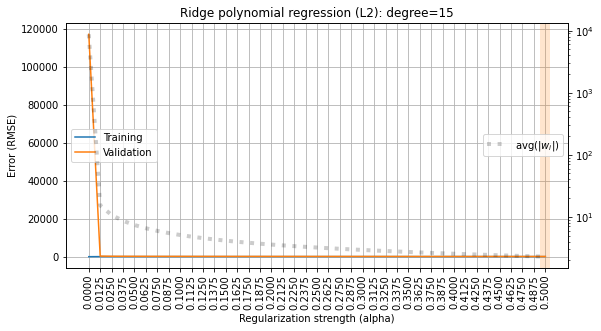

In [29]:
rmse_train, rmse_valid, avg_coef_l2 = [], [], []
for alpha in ALPHAS:  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
    model = make_model(penalty='L2', alpha=alpha)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_score = rmse(y_train, train_pred)
    test_pred = model.predict(X_test)
    test_score = rmse(y_test, test_pred)
    rmse_train.append(train_score)
    rmse_valid.append(test_score)
    avg_coef_l2.append(       
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            
        ]))
    print(train_score, test_score)
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l2, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary

Регуляризация уменьшает величину RMSE

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

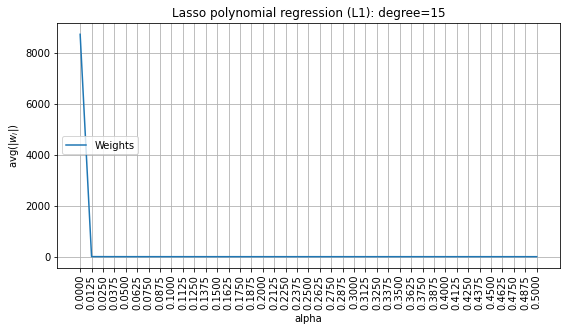

In [30]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, avg_coef_l1, label='Weights')
plt.title('Lasso polynomial regression (L1): degree=15')
plt.xlabel('alpha')
plt.ylabel('avg(|$w_i$|)')
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='center left')

In [31]:
avg_coef_l1

[8733.984761185327,
 2.65259132443818,
 1.4424816626733412,
 1.033078572770497,
 0.7093560389161021,
 0.5378691630344933,
 0.4314377408081695,
 0.3569558438695227,
 0.3080468752238576,
 0.26523494786102575,
 0.22738785165836517,
 0.20158849666415862,
 0.17800570749975428,
 0.15917801469939805,
 0.1461188613768589,
 0.13537309061722191,
 0.12799330680286772,
 0.12171530030540587,
 0.11664977392315326,
 0.11150913643761717,
 0.1069321457350069,
 0.10291243008071665,
 0.0989872447433976,
 0.09544136680306718,
 0.09219116719264836,
 0.0889814546974833,
 0.08635744215306163,
 0.08370299888276574,
 0.08124291010151144,
 0.0789394507049891,
 0.07665402754062978,
 0.07429483313979855,
 0.07197032309357591,
 0.0698155279615331,
 0.06770365795991215,
 0.0654618602834694,
 0.06396709639974796,
 0.06255770399838459,
 0.06130020390501618,
 0.06011519900508003,
 0.059050876683225464]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
model = make_model(penalty='L1', alpha=alpha)
model.fit(X_train, y_train)
(model['reg'].coef_ ==0).sum()

3839

In [33]:
X_train.shape

(331, 3881)

In [34]:
X_train.shape[1] - (model['reg'].coef_ ==0).sum()

42

#### L2

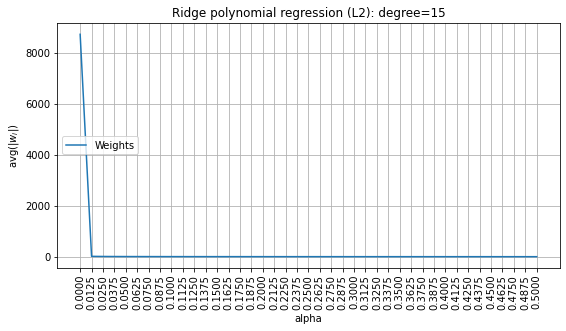

In [35]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, avg_coef_l2, label='Weights')
plt.title('Ridge polynomial regression (L2): degree=15')
plt.xlabel('alpha')
plt.ylabel('avg(|$w_i$|)')
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='center left')

In [36]:
avg_coef_l2

[8733.984761185327,
 15.281902695457166,
 10.690513713035429,
 8.619886310490829,
 7.385472691584166,
 6.546277925845708,
 5.936880036744256,
 5.469636539982007,
 5.097263351179093,
 4.793717495602407,
 4.538141815962577,
 4.3202417595085,
 4.131519766646953,
 3.9660659061518713,
 3.819811497076069,
 3.689657894916799,
 3.5727357453744015,
 3.466823323297402,
 3.369974204240786,
 3.281070278187188,
 3.199237960261206,
 3.1235927976540827,
 3.053168884417502,
 2.9873968772995307,
 2.9259291050866696,
 2.8683940024603367,
 2.814296061741585,
 2.763200102407874,
 2.714699042614291,
 2.668634112707177,
 2.624748250746304,
 2.5828600275040365,
 2.5430541602199015,
 2.505134390313362,
 2.468821043193578,
 2.433982668767006,
 2.400527294057169,
 2.3683929913584065,
 2.3375407691279233,
 2.3078265751301936,
 2.2791485352510468]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
model = make_model(penalty='L2', alpha=alpha)
model.fit(X_train, y_train)
(model['reg'].coef_ ==0).sum()

0

#### Summary

Регуляризация L1 из 170546 признаков оставила 108, при регуляризации L2 веса не зануляются

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [38]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [39]:
model = Lasso()
X_train, X_test, y_train, y_test = train_test_split(X_hw, y_hw, random_state=SEED)

model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_test)
test_score = rmse(y_test, test_pred)
print(test_score,'   ', train_score) 

6.550706403900472     6.5393201999509545


In [40]:
model.coef_

array([ 0.        , -0.00207834, -0.03139122])

In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_test)
test_score = rmse(y_test, test_pred)
print(test_score,'   ', train_score) 

3.7984320133282985     4.20675671762655


In [42]:
model.coef_

array([ 4.28229249, -0.        , -0.3855469 ])

#### L2

In [43]:
model = Ridge()
X_train, X_test, y_train, y_test = train_test_split(X_hw, y_hw, random_state=SEED)

model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_test)
test_score = rmse(y_test, test_pred)
print(test_score,'   ', train_score) 

6.454886853516748     6.410866781829229


In [44]:
print(model.coef_)

[ 5.50267081e+00 -2.05578558e-03 -3.16372265e-02]


In [45]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
train_score = rmse(y_train, train_pred)
test_pred = model.predict(X_test)
test_score = rmse(y_test, test_pred)
print(test_score,'   ', train_score) 

4.335780712881816     3.9640803245976137


In [46]:
print(model.coef_)

[ 5.08334463 -0.29885518 -1.32202705]


#### Summary



После проведения стандартизации RMSE уменьшилась и на тренировочной и на тестовой выборке